In [6]:
## Do nothing here, go to the next cell to visualize seam detection
## We just prepare useful functions here

import numpy as np
import matplotlib.pyplot as plt
import cv2

#import est_orientation 
#import edge_detect

def get_circle_mask(im0,const=1):
    '''
    Get a mask to crop out the baseball seam and 
    remove the boundary artifacts in the baseball image
    
    Input:
        im0 - grayscale and cropped image of the baseball
        const - ranges from 0 to 1 and used to retain
        all pixels within const*r of the center of the baseball
    
    Output:
        mask - binary mask specifying the pixels we want to analyze
        r - radius of the circular mask
        cx,cy - coordinates of the center of the circular mask
    '''
    
    bw = im0>0
    h,w = bw.shape
    numPix = np.sum(bw.flatten())
    r = np.sqrt(numPix/np.pi)
    xx,yy = np.meshgrid(range(w),range(h))
    cx = 1.*(np.sum(xx*bw))/numPix
    cy = 1.*(np.sum(yy*bw))/numPix

    mask = np.zeros((h,w))
    yy = range(h)
    xx = range(w)
    xx,yy = np.meshgrid(xx,yy)
    mask[ (1.*(xx-cx)**2+1.*(yy-cy)**2) <= 1.*(const*r)**2] =1
    
    return mask,r,cx,cy

def remove_noise(bw_in,min_size=30,frac=0.6):
    '''
    Remove all the connected components that are not part of the
    baseball seam. We assume that the baseball seam has at least
    min_size pixels and that the potentially second disjoint seam is within frac
    of the min_size.
    
    Input: 
        bw_in - Binary image of the output of an edge detection algorithm
        min_size - Minimum number of pixels for the seam
        frac - Fraction of the size of the largest fragment/seam to qualify 
        as a second (and disjoint) part of the seam
    
    Output: 
        bw - cleaned up binary image of the "seam"
    '''
    num,output,stats,_= cv2.connectedComponentsWithStats(
        bw_in.astype('uint8'),connectivity=4)
    sizes = stats[:,-1]
    sort_indx = np.argsort(sizes)
    best_indx = sort_indx[-2]
    largest_seg = sizes[best_indx]
    
    bw = 0*np.zeros(bw_in.shape)
    if largest_seg > min_size:
        bw = output==best_indx
        # Need to make this a threshold
        if len(sort_indx) > 2:
            sec_largest_seg = sizes[sort_indx[-3]]
            if sec_largest_seg > frac*(largest_seg):
                bw += output==sort_indx[-3]
    return bw

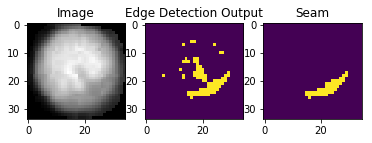

In [7]:
# We extract cropped images of the baseball and saved them as images
# to analyze the data

# Parameters that we change
# Frame index
indx = 11 # In this example, frames with the baseball range from 0 to 26
im0 = cv2.imread('ball1/ball'+str(indx)+'.png',-1)


filtSize = 5 # Size of the blur filter
sigma = 70 # Bilateral filter parameter
lap_size = 5 # Laplacian size

mask_radius = 0.75 # Circular mask parameter
min_size = 30 # Minimum size for seam
frac = 0.6 # Potentially second seam

############ Perform the edge detection here ################

# Use either bilateral or median filter
#blurred = cv2.bilateralFilter(im0, 5, sigma, sigma)
blurred = cv2.medianBlur(im0,filtSize)
edge = cv2.Laplacian(blurred, cv2.CV_64F,ksize=lap_size)>0

# Remove the boundary of the edge
mask,r,cx,cy = get_circle_mask(im0,const=mask_radius)
edge = edge*mask

# Get the seam
seam = remove_noise(edge,min_size=min_size,frac=frac) # Remove the small artifacts in the edge detection output
seam = seam.astype(np.uint8)

## Find the best estimated seam
#xyz,minCost,xaxis,R = est_orientation.best_orientation3(seam,r,[cx,cy])

########################### Visualize Results #########################
plt.subplot(1,3,1)
plt.imshow(im0,cmap='gray')
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(edge)
plt.title('Edge Detection Output')

plt.subplot(1,3,3)
plt.imshow(seam)
plt.title('Seam')

#plt.subplot(2,2,4)
#plt.imshow(seam)
#good_indx = xyz[2,:]>0
#plt.plot(r*xyz[0,good_indx]+cx,r*xyz[1,good_indx]+cy,'o')
#plt.title('Seam, Estimated Overlaid')

plt.show()
